# Trufl
> Optimizing adaptive sampling using Multiple-criteria decision-making

**Trufl** was initiated in the context of the [IAEA (International Atomic Energy Agency)](https://www.iaea.org) Coordinated Research Project titled ["Monitoring and Predicting Radionuclide Uptake and Dynamics for Optimizing Remediation of Radioactive Contamination in Agriculture"](https://www.iaea.org/newscenter/news/new-crp-monitoring-and-predicting-radionuclide-uptake-and-dynamics-for-optimizing-remediation-of-radioactive-contamination-in-agriculture-crp-d15019).

While **Trufl** was originally developed to address the remediation of farmland affected by nuclear accidents, its approach and algorithms are **applicable to a wide range of application domains**. This includes managing **legacy contaminants or monitoring any phenomenon that requires consideration of multiple decision criteria**, potentially involving a large set of data.

This package leverages the work done by [Floris Abrams](https://www.linkedin.com/in/floris-abrams-59080a15a) in the context of his PhD at [KU Leuven](https://www.kuleuven.be) and [Franck Albinet](https://www.linkedin.com/in/franckalbinet), International Consultant in Geospatial Data Science and currently PhD researcher in AI applied to nuclear remedation at KU Leuven.


## Install

`pip install trufl`

## Getting started

In highly sensitive and high-stakes situations, it is **essential that decision making is informed, transparent, and accountable**, with decisions being based on a thorough and objective analysis of the available data and the needs and concerns of affected communities being taken into account.

Given the time constraints and limited budgets that are often associated with data surveys (in particular ones supposed to informed highligh sensitive situation), it is **crucial to make informed decisions about how to allocate resources**. This is even more important when considering the many variables that can be taken into account, such as prior knowledge of the area, health and economic impacts, land use, whether remediation has already taken place, population density, and more. Our approach leverages Linear Programming techniques such as **Multiple-criteria decision-making** to optimize the data survey workflow:

In this demo, we will walk you through a **typical workflow** using the `Trufl` package. To help illustrate the process, we will use a "toy" dataset that represents a typical spatial pattern of soil contaminants.

1. We **assume that we have access to the ground truth**, which is a raster file that shows the spatial distribution of a soil contaminant;
2. We will make decisions about how to sample and how much at **administrative units** level, which in this case are **simulated as a grid** (using the `gridder` utilities function);
3. Based on prior knowledge of the phenomenon of interest, such as prior airborne surveys or other data, an `Optimizer` will **rank each grid cell according to its priority for sampling**;
4. We will then **perform random sampling on the designated grid cells** (using a `Sampler`). To simulate the measurement process, we will use the ground truth to emulate measurements at each location (using a `DataCollector`);
5. We will **evaluate the new state of each cell based on the measurements** and **pass it to a new round of optimization**. This process will be repeated iteratively to refine the sampling strategy.

In [16]:
#| hide
import warnings
warnings.filterwarnings('ignore')

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Imports

In [17]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import rasterio
import geopandas as gpd

from trufl.utils import gridder
from trufl.sampler import Sampler, rank_to_sample
from trufl.collector import DataCollector
from trufl.callbacks import (State, MaxCB, MinCB, StdCB, CountCB, MoranICB, PriorCB)
from trufl.optimizer import Optimizer

red, black = '#BF360C', '#263238'

### Our simulated ground truth

The assumed ground truth reveals a typical spatial pattern of contaminant such as `Cs137` after a nuclear accident for instance.

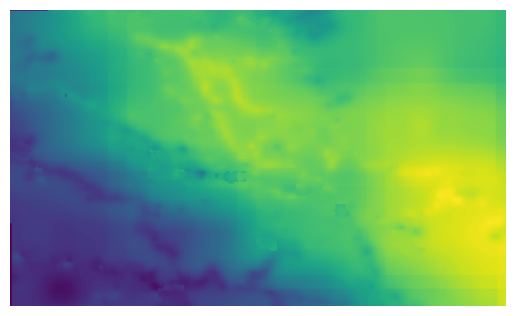

In [18]:
fname_raster = './files/ground-truth-01-4326-simulated.tif'
with rasterio.open(fname_raster) as src:
    plt.axis('off')
    plt.imshow(src.read(1))

### Simulate administrative units

The sampling strategy will be determined on a per-grid-cell basis within the administrative unit. We define below a 10 x 10 grid over the area of interest:

In [19]:
gdf_grid = gridder(fname_raster, nrows=10, ncols=10)
gdf_grid.head()

,geometry
loc_id,
0,"POLYGON ((-1.20830 43.26950, -1.20830 43.26042..."
1,"POLYGON ((-1.20830 43.27858, -1.20830 43.26950..."
2,"POLYGON ((-1.20830 43.28766, -1.20830 43.27858..."
3,"POLYGON ((-1.20830 43.29673, -1.20830 43.28766..."
4,"POLYGON ((-1.20830 43.30581, -1.20830 43.29673..."


:::{.callout-tip}

Note how each administrative unit is uniquely identified by its `loc_id`.

:::

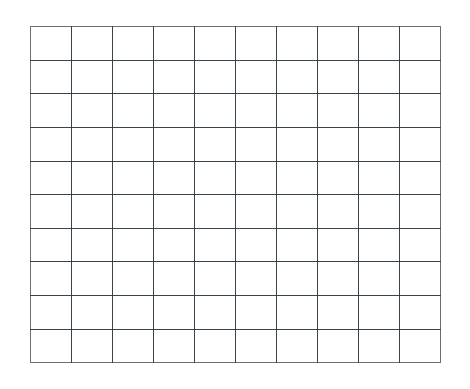

In [20]:
gdf_grid.boundary.plot(color=black, lw=0.5)
plt.axis('off');

### What prior knowledge do we have?

At the initial time $t_0$, data sampling has not yet begun, but we can often **leverage existing prior knowledge of our phenomenon** of interest to inform our sampling strategy/policy. In the context of nuclear remediation, this prior knowledge can often be obtained through mobile surveys, such as airborne or carborne surveys, which can provide a **coarse estimation** of soil contamination levels.

In the example below, we **simulate prior information about the soil property of interest by calculating the average value of the property over each grid cell**.

At this stage, we have no measurements, so we simply create an empty [Geopandas GeoDataFrame](https://geopandas.org/en/stable/docs/reference/api/geopandas.GeoDataFrame.html). 

In [21]:
samples_t0 = gpd.GeoDataFrame(index=pd.Index([], name='loc_id'), 
                              geometry=None, data={'value': None})

:::{.callout-tip}

We need to set an index `loc_id` and have a `geometry` and `value` columns.

:::

Now we get/"sense" the state of our grid cells based on the simulated prior (Mean over each grid cell `PriorCB`):

In [22]:
state = State(samples_t0, gdf_grid, cbs=[PriorCB(fname_raster)])

# You have to call the instance
state_t0 = state(); state_t0.head()

,Prior
loc_id,
0,0.102492
1,0.125727
2,0.161802
3,0.184432
4,0.201405


:::{.callout-tip}

We get the `Prior` for each individual `loc_id` (here only the first 5 shown). The current `State` is only composed of a single `PriorCB` variable but can include many more variables as we will see below. 

:::

### Optimize sampling based on prior at $t_0$

In [23]:
# Bugs?
#   - fails when ran twice

benefit_criteria = [True]
optimizer = Optimizer(state=state_t0)
df_rank = optimizer.get_rank(is_benefit_x=benefit_criteria, w_vector = [1],  
                             n_method=None, c_method = None, 
                             w_method=None, s_method="CP")

df_rank.head()

,rank
loc_id,
92,1
93,2
91,3
94,4
82,5


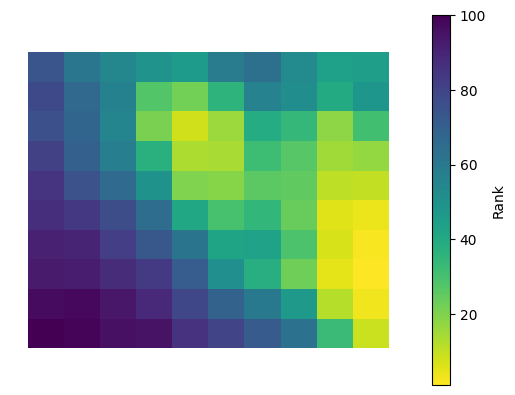

In [24]:
gdf_grid.join(df_rank, how='left').plot(column='rank',
                                        cmap='viridis_r', 
                                        legend_kwds={'label': 'Rank'}, 
                                        legend=True)
plt.axis('off');

### Start sampling

:::{.callout-tip}

It's worth noting that in the absence of any prior knowledge, a uniform sampling strategy over the area of interest may be used. However, this approach may not be the most efficient use of the available data collection and analysis budget.

:::

Based on the **ranks (sampling priority)** calculated by the `Optimizer` and given sampling **budget**, let's calculate the number of samples to be collected for each administrative unit (`loc_id`):

In [25]:
n = rank_to_sample(df_rank['rank'].sort_index().values, 
                   budget=300, min=1); n

array([ 1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  2,  3,  2,  1,  1,  1,  1,  1,  1,  3,  4,  7,  3,  1,  1,
        1,  1,  1,  2,  3,  4,  4,  2,  1,  1,  1,  2,  1,  2,  2,  2,  1,
        1,  1,  1,  1,  3,  2,  2,  2,  2,  2,  1,  1,  2,  5, 12,  8, 10,
        5,  4,  3,  1,  1,  6, 19, 58, 29, 14,  6,  3,  2,  1,  1])

We can now decide where to sample based on this sampling schema:

                         geometry
loc_id                           
0       POINT (-1.21456 43.26263)
1       POINT (-1.20867 43.27768)
2       POINT (-1.20871 43.28523)
3       POINT (-1.22310 43.29630)
4       POINT (-1.22009 43.30185)


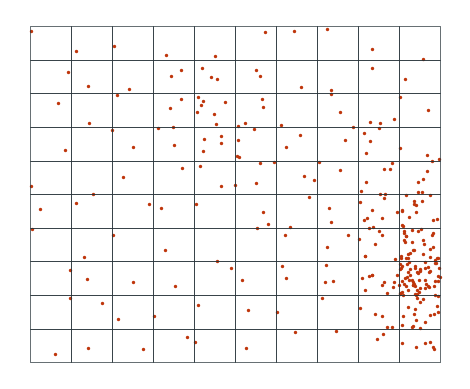

In [26]:
sampler = Sampler(gdf_grid)
sample_locs_t0 = sampler.sample(n, method='uniform')

print(sample_locs_t0.head())
ax = sample_locs_t0.plot(markersize=2, color=red)

gdf_grid.boundary.plot(color=black, lw=0.5, ax=ax)
plt.axis('off');

### Emulating data collection and analysis

The data collector collects measurements at the random sampling locations in the field. In our case, we emulate this process by extracting measurements from the provided raster file.

"Measuring" variable of interest from a given raster:

                         geometry     value
loc_id                                     
0       POINT (-1.21456 43.26263)  0.116546
1       POINT (-1.20867 43.27768)  0.146491
2       POINT (-1.20871 43.28523)  0.161705
3       POINT (-1.22310 43.29630)  0.201974
4       POINT (-1.22009 43.30185)  0.219040


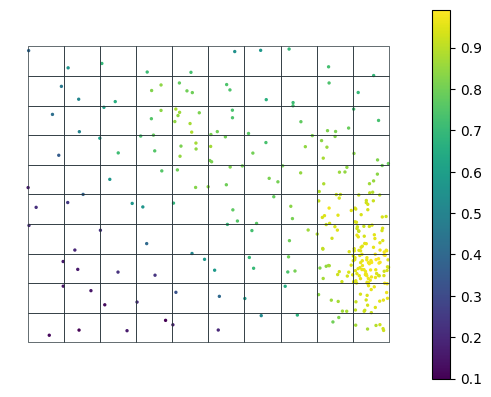

In [27]:
dc_emulator = DataCollector(fname_raster)
samples_t0 = dc_emulator.collect(sample_locs_t0)

print(samples_t0.head())
ax = samples_t0.plot(column='value', s=2, legend=True)
gdf_grid.boundary.plot(color=black, lw=0.5, ax=ax);
plt.axis('off');

### Getting current state

In [28]:
state = State(samples_t0, gdf_grid, cbs=[
    MaxCB(), MinCB(), StdCB(), CountCB(), MoranICB(k=5), PriorCB(fname_raster)
])

# You have to call the instance
state_t0 = state(); state_t0

,Max,Min,Standard Deviation,Count,Moran.I,Prior
loc_id,,,,,,
0,0.116546,0.116546,0.000000,1,NaN,0.102492
1,0.146491,0.146491,0.000000,1,NaN,0.125727
2,0.161705,0.161705,0.000000,1,NaN,0.161802
3,0.201974,0.201974,0.000000,1,NaN,0.184432
4,0.219040,0.219040,0.000000,1,NaN,0.201405
...,...,...,...,...,...,...
95,0.902863,0.799127,0.034321,6,0.785949,0.803670
96,0.836919,0.788598,0.020284,3,NaN,0.763408
97,0.729653,0.721891,0.003881,2,NaN,0.727797


## Determine the ranking of the administrative polygons

Then ranking is based on the importance to sample more in the polygon. A multi criteria decision aiding methodology is used the rank the parcels from important to sample more (low rank) less important.

**Criteria**
The state of the polygon will be used as criteria to determine the rank

| Criteria | State variable | Criteria Type |
|----------|----------|----------|----------|
|  Estimated value    |   PriorCB()  |  Benefit  |
|  Maximum sample value  |   MaxCB()  |   Benefit  |
|  Minimal sample value  |   MinCB()  |   Benefit  |
|   Sample count  |   CountCB()  |   Cost  |
|   Standard deviation  |   StdCB()  |   Benefit  |
|   Moran I index  |   MoranICB(k=5)  |   Cost  |

**Criteria type**
Criteria can be of the type benefit or cost 
- Benefit (**high values** equal high importance to sample more)
- Cost (**low value** equal high importance to sample more)

**Weights**
A weight vector is used to determine the importance of criteria in comparison with each other

**MCDM techniques**
- Compromise programmin (CP)
    - Distance based measure, where the distance to the optmal point is used (low values --> good alternative)
- TOPSIS (TOPSIS)
    - Distance based measure, where the closeness to the optimal point and anti optimal point is measured (high values --> good alternative)

**Rank**
The based on the MCDM value a ranking of the polygons is created


In [46]:
benefit_criteria = [True, True, True]
state = State(samples_t0, gdf_grid, cbs=[MaxCB(), MinCB(), StdCB()])
optimizer = Optimizer(state=state())
df = optimizer.get_rank(is_benefit_x=benefit_criteria, w_vector = [0.3, 0.3, 0.4],  
                    n_method="LINEAR1", c_method = None, w_method=None, s_method="TOPSIS")

df.head()

,rank
loc_id,
82,1
95,2
73,3
37,4
66,5


### Optimize sampling at $t_1$ based on criteria determined from at $t_0$

In [31]:
# https://kapernikov.com/ipywidgets-with-matplotlib/